# Data processing Garissa
This notebook processes the two .csv files that were provided by the WRA for Garissa. On of the issues with the file was inconsistent date formatting and date mismatches between discharge and water level data. They are first processed and plotted separately and then added together to create a single large dataset. Interactive Visualisation using VegaAltair is provided to assist in manual data inspection. Data is saved back as a .csv file but now with consistent formatting and date-matched entries. 

Known issue: Some double time entries are interpreted in such a way that they combine into a single value, leading to outliers. 

In [2]:
import numpy as np
import pandas as pd
import pathlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import sys
import os.path
from matplotlib.ticker import MaxNLocator
import warnings

In [3]:
# If errors occur here please refer to the readme file or to the file_imports.py folders. 

cwd = pathlib.Path().resolve()
src = cwd.parent
data = src.parent.parent.parent
root = src.parent
sys.path.append(str(src))
sys.path.append(str(root))
from utils.file_imports import *


data_paths = file_paths(root, WRA = True)
Garissa_files = data_paths[0]

The first entry is pointing to /Users/matskerver/Documents/data_tana/WRA/Garissa_station, the second one to /Users/matskerver/Documents/data_tana/WRA/other_stations and


In [4]:
import altair as alt #Needed for interactive visualization, can be commented if desired.
from utils.altair_visualisation import * 

# Recent data Garissa processing

In [5]:
#Replace with your own data
path = os.path.join(Garissa_files, 'Garissa_Tana_recent.csv')
df_garissa_recent = pd.read_csv(path, sep = ';')
df_garissa_recent = df_garissa_recent.dropna(how = 'all')


# Some required data cleanup. Some empty columns are removed, the hourly data is removed and the 
# columns are renamed for later purpose
columns_to_drop = [2, 3]  
df_garissa_recent = df_garissa_recent.drop(df_garissa_recent.columns[columns_to_drop], axis=1)
df_garissa_recent = df_garissa_recent[21:]
df_garissa_recent = df_garissa_recent.rename(columns={"Time": "date_level", "4G01-TANA-WATER LEVEL-RAW": "waterlevel[m]",
                                                     "Time.1":"date_discharge", "4G01-TANA-DISCHARGE": "discharge[m3/s]"})

#Convert the (mixed) time dataset into a standard datetime format 
df_garissa_recent['date_level'] = pd.to_datetime(df_garissa_recent['date_level'], format='mixed')
df_garissa_recent['date_discharge'] = pd.to_datetime(df_garissa_recent['date_discharge'], format='mixed')


In [6]:
# To compare the mismatched timesteps the dataset is split-up into two different datasets:
# The discharge contains the date and discharge and time, the other water level and time
columns_discharge = [2,3]
columns_level = [0,1]
df_garissa_matched = df_garissa_recent.drop(df_garissa_recent.columns[columns_discharge], axis =1)
df_garissa_discharge = df_garissa_recent.drop(df_garissa_recent.columns[columns_level], axis =1)

In [7]:
# Due to some strange formatting of the data some entries are double or missing. This function removes any
# mismatching data entries ensuring that the top entry of each dataset is the same timestamp in the same format

def remove_row(df_garissa_matched, df_garissa_discharge):
    if df_garissa_matched.empty or df_garissa_discharge.empty: # Stop the function if the dataset is empty
        return df_garissa_matched, df_garissa_discharge
    if df_garissa_matched.iloc[0, 0] == df_garissa_discharge.iloc[0, 0]: # Stop the function if entries match
        return df_garissa_matched, df_garissa_discharge
    elif df_garissa_discharge.iloc[0, 0].timestamp() - df_garissa_matched.iloc[0, 0].timestamp() > 0: 
        df_garissa_matched = df_garissa_matched[1:]  #Remove the first water level entry if needed
        return remove_row(df_garissa_matched, df_garissa_discharge) # Recursively restart function to check again
    else:
        df_garissa_discharge = df_garissa_discharge[1:] # Remove discharge entry if needed
        return remove_row(df_garissa_matched, df_garissa_discharge) # Recursively restart function to check again
        

In [8]:
# Nasty bit of code that Jenga tower like removes the first entry of the dataset (after matching times are ensured)
# and adds it to a new dataset containing the matched data in a new dataframe. This dataframe will contain three
# columns: water level, discharge and a timestamp. 

run_recent_tana = True #Change to true if needed.

if run_recent_tana == True: 
    unready = True
    matched_data = pd.DataFrame() # empty dataframe for the water level and date
    discharge = [] # empty array for the discharge
    safety_stop = 0   
    safety_stop_max = len(df_garissa_discharge) #prevent infinite loop in case data format is incorrect 

    # Looping through entire dataset. 

    while unready:
        safety_stop += 1
        df_garissa_matched, df_garissa_discharge = remove_row(df_garissa_matched, df_garissa_discharge) #run remove 
        if safety_stop > safety_stop_max:
            unready = False
            warnings.warn("Dataset not in expected format, conversion failed")
        if df_garissa_matched.empty or df_garissa_discharge.empty: # Check needs to happen twice to break out of 
            #both the function and the loop.
            unready = False
            break

        # Data manipulation into the correct format

        discharge.append(df_garissa_discharge.iloc[0,1])
        new_level = df_garissa_matched.iloc[0,:].to_frame().T
        matched_data = pd.concat([matched_data, new_level], ignore_index=True)
        df_garissa_matched = df_garissa_matched[1:]

    #Adding the discharge array and completing the Dataset
    discharge_column = pd.Series(discharge, name='discharge[m3/s]')
    matched_data = pd.concat([matched_data, discharge_column], axis=1)

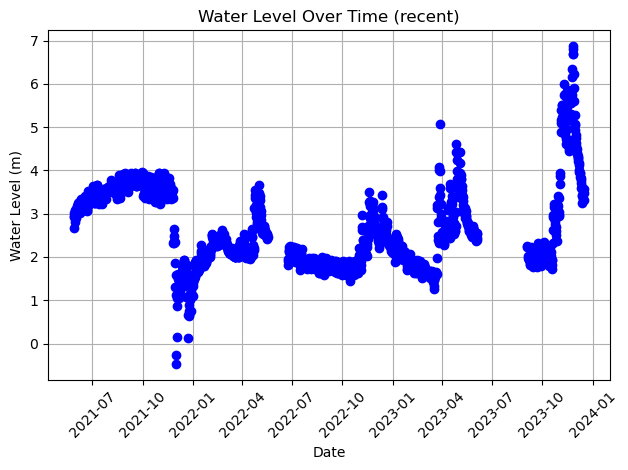

In [9]:
n = 12  # Plot every nth data point
plt.plot(matched_data['date_level'][::n], matched_data['waterlevel[m]'][::n], marker='o', linestyle='', color='b')
plt.xlabel('Date')
plt.ylabel('Water Level (m)')
plt.title('Water Level Over Time (recent)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [10]:
# Save the dataframe to a csv file at the previously defined location 
path = os.path.join(Garissa_files, 'fixed_recent_data_Garissa.csv')
matched_data.to_csv(path, index = False)

# Historical data Garissa processing 

In [11]:
#Replace with your own data
path = os.path.join(Garissa_files, 'Garissa_Tana_historical.csv')
df_garissa_his = pd.read_csv(path, sep = ';')
df_garissa_his = df_garissa_his.dropna()

# Some required data cleanup. Some empty columns are removed, one date column is removed (duplicate) and the 
# columns are renamed for later purpose.
# Every water level point is already aligned with the discharge so no further manipulation is needed. 

columns_to_drop = [0,3]  
df_garissa_his = df_garissa_his.drop(df_garissa_his.columns[columns_to_drop], axis=1)
df_garissa_his = df_garissa_his.rename(columns={"Time": "date", "4G01 TANA GARISSA - WaterLevel [m]": "waterlevel[m]",
                                                    "4G01 TANA GARISSA DISCHARGE [m^3/s]": "discharge[m3/s]"})

df_garissa_his['date'] = pd.to_datetime(df_garissa_his['date'], format='mixed')

In [12]:
df_garissa_his.head()

,date,waterlevel[m],discharge[m3/s]
0,1941-04-18,5.27,1683.0030
2,1941-04-19,5.18,1609.1140
6,1941-04-21,4.88,1377.3840
8,1941-04-22,4.58,1167.4480
10,1941-04-23,2.76,351.5418


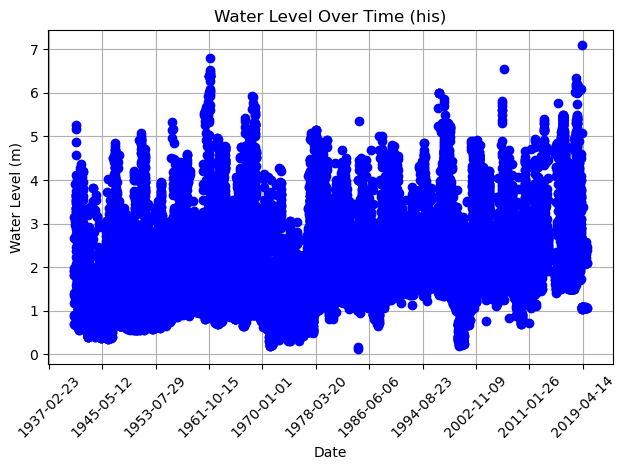

In [13]:
n = 1  # Plot every nth data point
plt.plot(df_garissa_his['date'][::n], df_garissa_his['waterlevel[m]'][::n], marker='o', linestyle='', color='b')
plt.xlabel('Date')
plt.ylabel('Water Level (m)')
plt.title('Water Level Over Time (his)')
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=12)) # prevent each date from being printed, maximum 12 now
plt.grid(True)
plt.tight_layout()
plt.show()

In [14]:
# Save the historical data to the previously defined location. 
path = os.path.join(Garissa_files, 'fixed_historical_data_Garissa.csv')
df_garissa_his.to_csv(path, index = False)

# Combined recent and historical data

In [15]:
matched_data.columns.values[0] = 'date'
Garissa_data_all = pd.concat([df_garissa_his, matched_data], axis=0)

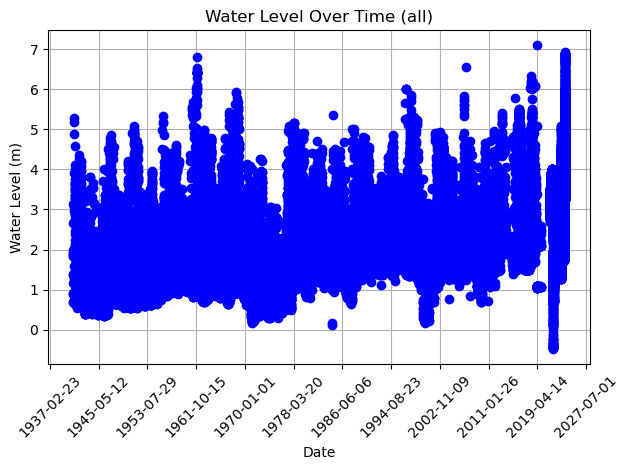

In [16]:
n = 1  # Plot every nth data point
plt.plot(Garissa_data_all['date'][::n], Garissa_data_all['waterlevel[m]'][::n], marker='o', linestyle='', color='b')
plt.xlabel('Date')
plt.ylabel('Water Level (m)')
plt.title('Water Level Over Time (all)')
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=12)) # prevent each date from being printed, maximum 12 now
plt.grid(True)
plt.tight_layout()
plt.show()

In [17]:
# Save the historical data to the previously defined location.
path = os.path.join(Garissa_files, 'fixed_all_data_Garissa.csv')
Garissa_data_all.to_csv(path, index = False)

## Interactive Visualisation
In case more specific timeframs need to be manually inspected it is easier to use a interactive visualisation package like VegaAltair. Here it is possible to manually specify a timeframe and interactively zoom in and out of graphs. 

In [24]:
df_garissa_all = pd.read_csv(path, sep = ',')
df_garissa_all['date'] = pd.to_datetime(df_garissa_all['date'], format = 'mixed')
df_garissa_all = df_garissa_all.rename(columns={"date_level": "date", "waterlevel[m]": "waterlevel(m)",
                                                    "discharge[m3/s]": "discharge(m3/s)"})

scatter_tana = Graph_tana(df_garissa_all)

#Specifications to be added by the User for the desired time period
start_date = '2023-10-01'
end_date = '2023-12-31'
warning_level = 3.5
y_axis_name = 'waterlevel(m)'

scatter_tana.scatterplot_waterlevel(start_date, end_date, warning_level, y_axis_name)

alt.Chart(...)